In [ ]:
import pandas as pd
from collections import Counter
from google.colab import drive
drive.mount('/content/drive')
!pip install missingno
import missingno as msno
!pip install fuzzywuzzy
from fuzzywuzzy import fuzz

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.7/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/EMSE 6574 Project/cleaned_data_2021.csv')
df = df.drop('Unnamed: 0',axis=1)
df.head()

,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,state
0,33590,2014,gmc,sierra 1500 crew cab slt,good,8 cylinders,gas,57923.0,clean,other,NaN,NaN,pickup,white,al
1,22590,2010,chevrolet,silverado 1500,good,8 cylinders,gas,71229.0,clean,other,NaN,NaN,pickup,blue,al
2,39590,2020,chevrolet,silverado 1500 crew,good,8 cylinders,gas,19160.0,clean,other,NaN,NaN,pickup,red,al
3,30990,2017,toyota,tundra double cab sr,good,8 cylinders,gas,41124.0,clean,other,NaN,NaN,pickup,red,al
4,15000,2013,ford,f-150 xlt,excellent,6 cylinders,gas,128000.0,clean,automatic,rwd,full-size,truck,black,al


# 1. Fill missing data

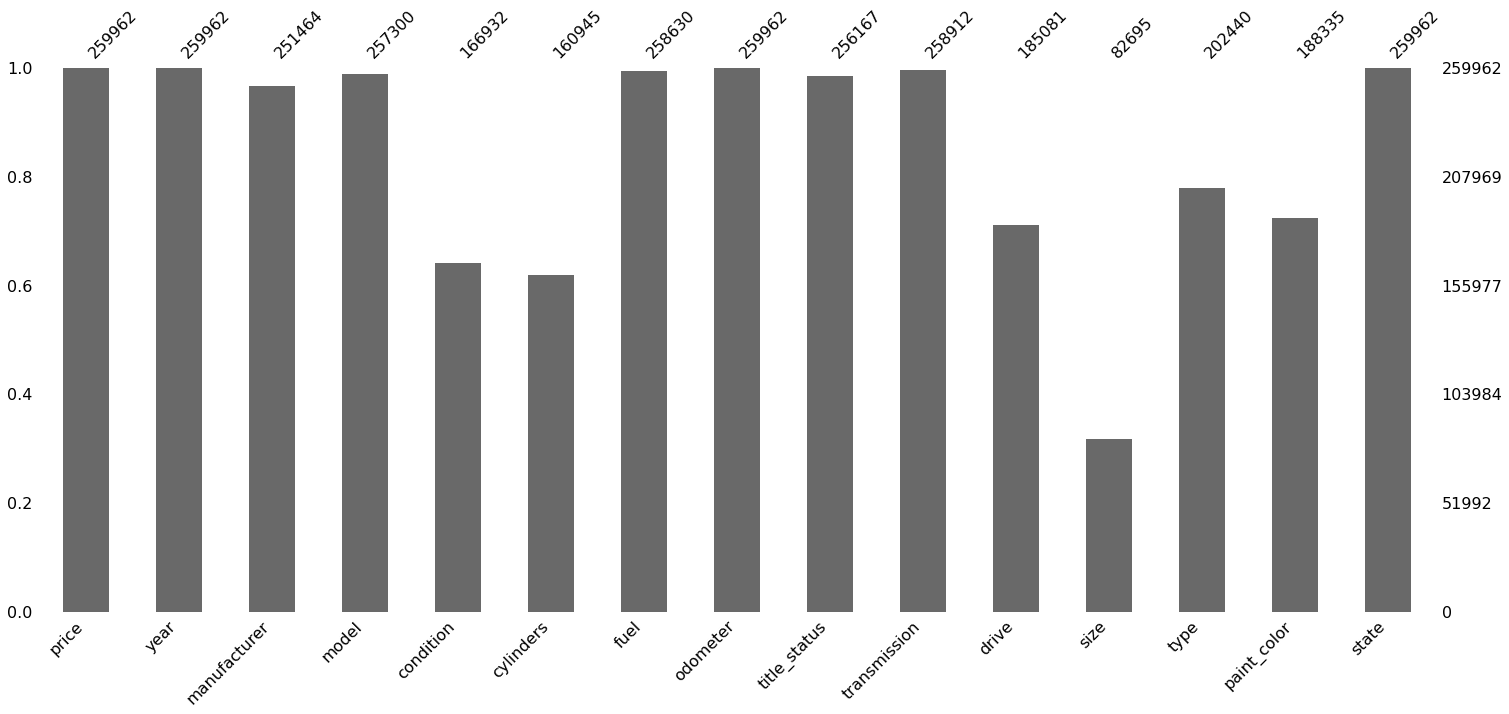

In [ ]:
msno.bar(df)

In [ ]:
null = pd.DataFrame({'Count': df.isnull().sum(), 'Percent': 100*cars_2021.isnull().sum()/len(cars_2021)})
null[null['Count'] > 0]

,Count,Percent
manufacturer,8498,0.0
model,2662,0.0
condition,93030,0.0
cylinders,99017,0.0
fuel,1332,0.0
title_status,3795,0.0
transmission,1050,0.0
drive,74881,0.0
size,177267,0.0
type,57522,0.0


For categorical variables, we noticed that there are several variables have missing data. It will affect EDA and prediction if we remove all these columns. So we decide to keep them and fill the missing values with "UNKNOWN" .

In [ ]:
df.fillna(value='UNKNOWN',inplace=True)

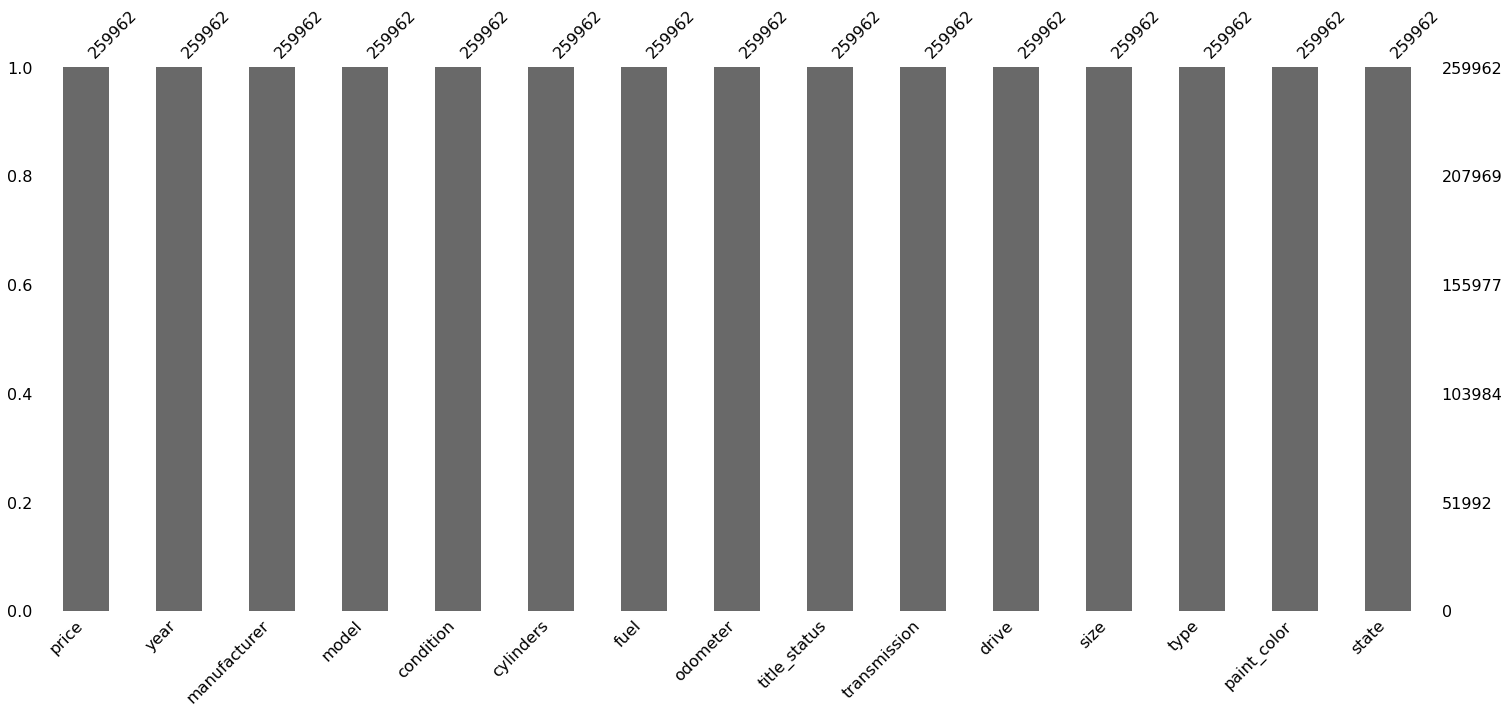

In [ ]:
msno.bar(df)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 259962 entries, 0 to 259961
Data columns (total 15 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   price         259962 non-null  int64  
 1   year          259962 non-null  int64  
 2   manufacturer  259962 non-null  object 
 3   model         259962 non-null  object 
 4   condition     259962 non-null  object 
 5   cylinders     259962 non-null  object 
 6   fuel          259962 non-null  object 
 7   odometer      259962 non-null  float64
 8   title_status  259962 non-null  object 
 9   transmission  259962 non-null  object 
 10  drive         259962 non-null  object 
 11  size          259962 non-null  object 
 12  type          259962 non-null  object 
 13  paint_color   259962 non-null  object 
 14  state         259962 non-null  object 
dtypes: float64(1), int64(2), object(12)
memory usage: 29.8+ MB


Now out dataset has 259962 rows and 14 columns, also we don't have any missing values.

# 2. Processing of 'model' column --Fuzzy Matching

Fuzzy matching is to approximately match strings and determine how similar they are. We want to use fuzzy matching to classify values in 'model' variable.

We have tried three choices of popular model names: top 30, top 50, top 30 model names add all manufacturer names.

The result is top 30 model names add all manufacturer names got the best prediction accuracy

In [ ]:
# create a new column contains both manufacturer and model
df['manu_model'] = df['manufacturer'] + ' ' + df['model']
df.head()

,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,state,manu_model
0,33590,2014,gmc,sierra 1500 crew cab slt,good,8 cylinders,gas,57923.0,clean,other,UNKNOWN,UNKNOWN,pickup,white,al,gmc sierra 1500 crew cab slt
1,22590,2010,chevrolet,silverado 1500,good,8 cylinders,gas,71229.0,clean,other,UNKNOWN,UNKNOWN,pickup,blue,al,chevrolet silverado 1500
2,39590,2020,chevrolet,silverado 1500 crew,good,8 cylinders,gas,19160.0,clean,other,UNKNOWN,UNKNOWN,pickup,red,al,chevrolet silverado 1500 crew
3,30990,2017,toyota,tundra double cab sr,good,8 cylinders,gas,41124.0,clean,other,UNKNOWN,UNKNOWN,pickup,red,al,toyota tundra double cab sr
4,15000,2013,ford,f-150 xlt,excellent,6 cylinders,gas,128000.0,clean,automatic,rwd,full-size,truck,black,al,ford f-150 xlt


In [ ]:
# grab the top 30 models

counter = Counter(df['manu_model'])
popular_model = counter.most_common()[:30]
temp_popular_model_names = []
for m in popular_model:
    temp_popular_model_names.append(m[0])

# add all manufacturers and top 30 popular names together 
popular_model_names = temp_popular_model_names + list(df['manufacturer'].unique())

# put all the other model value in a new Series
other = df[~df['manu_model'].isin(popular_model_names) ]['manu_model']

In [ ]:
popular_model_names

['ford f-150',
 'chevrolet silverado 1500',
 'ram 1500',
 'toyota camry',
 'honda accord',
 'honda civic',
 'chevrolet silverado',
 'nissan altima',
 'ford escape',
 'jeep wrangler',
 'toyota tacoma',
 'jeep grand cherokee',
 'ford explorer',
 'toyota corolla',
 'ram 2500',
 'honda cr-v',
 'ford mustang',
 'ford focus',
 'chevrolet equinox',
 'ford fusion',
 'toyota rav4',
 'honda odyssey',
 'subaru outback',
 'chevrolet malibu',
 'hyundai sonata',
 'chevrolet tahoe',
 'chevrolet impala',
 'toyota prius',
 'dodge grand caravan',
 'subaru forester',
 'gmc',
 'chevrolet',
 'toyota',
 'ford',
 'jeep',
 'nissan',
 'ram',
 'mazda',
 'cadillac',
 'honda',
 'dodge',
 'lexus',
 'jaguar',
 'buick',
 'chrysler',
 'volvo',
 'audi',
 'infiniti',
 'lincoln',
 'alfa-romeo',
 'subaru',
 'UNKNOWN',
 'acura',
 'hyundai',
 'mercedes-benz',
 'bmw',
 'mitsubishi',
 'volkswagen',
 'porsche',
 'kia',
 'rover',
 'ferrari',
 'mini',
 'pontiac',
 'fiat',
 'tesla',
 'saturn',
 'mercury',
 'harley-davidson',
 'a

Partial_ratio is better. There will be some models fit in more than 1 popular_model_names, for example 5 100.

In [ ]:
def match_popular(word, name_list):
    '''
    This function is to make all the values in other to fuzzy match popular model names.
    INPUT:
    word: values in 'other' column
    name_list: values in 'popular_model_names'
    OUTPUT:
    
    '''
    max_score = -99999
    max_name = word
    for name in name_list:
        temp_score = fuzz.partial_ratio(word, name)
        if temp_score > max_score:
            max_score = temp_score
            max_name = name
    if max_score<=50:
        return 'other', max_score
    return max_name, max_score

In [ ]:
df['model_class'] = df['manu_model'].apply(lambda x: match_popular(x, popular_model_names)[0])
df.head()

,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,state,manu_model,model_class
0,33590,2014,gmc,sierra 1500 crew cab slt,good,8 cylinders,gas,57923.0,clean,other,UNKNOWN,UNKNOWN,pickup,white,al,gmc sierra 1500 crew cab slt,gmc
1,22590,2010,chevrolet,silverado 1500,good,8 cylinders,gas,71229.0,clean,other,UNKNOWN,UNKNOWN,pickup,blue,al,chevrolet silverado 1500,chevrolet silverado 1500
2,39590,2020,chevrolet,silverado 1500 crew,good,8 cylinders,gas,19160.0,clean,other,UNKNOWN,UNKNOWN,pickup,red,al,chevrolet silverado 1500 crew,chevrolet silverado 1500
3,30990,2017,toyota,tundra double cab sr,good,8 cylinders,gas,41124.0,clean,other,UNKNOWN,UNKNOWN,pickup,red,al,toyota tundra double cab sr,toyota
4,15000,2013,ford,f-150 xlt,excellent,6 cylinders,gas,128000.0,clean,automatic,rwd,full-size,truck,black,al,ford f-150 xlt,ford f-150


* 'fuzz': temp_model_name=30, number of other is 73347, nunique:31
* 'fuzz2': temp_model_name=50, number of other is 60288, nunique:51
* 'fuzz3': popular_model_name= temp_model_name(30) + all manufacture name, number of other is 0, nunique:70

In [ ]:
df.to_csv('/content/drive/MyDrive/EMSE 6574 Project/fuzzy_matched_model.csv')

# 3. Onehot Encode

In [ ]:
df.columns

Index(['price', 'year', 'manufacturer', 'model', 'condition', 'cylinders',
       'fuel', 'odometer', 'title_status', 'transmission', 'drive', 'size',
       'type', 'paint_color', 'state', 'manu_model', 'model_class'],
      dtype='object')

In [ ]:
df_dummied = pd.get_dummies(df, columns=['condition', 'cylinders',
       'fuel','title_status', 'transmission', 'drive', 'size',
       'type', 'paint_color', 'state', 'model_class'], drop_first=True)
df_dummied.head()

,price,year,manufacturer,model,odometer,manu_model,condition_excellent,condition_fair,condition_good,condition_like new,condition_new,condition_salvage,cylinders_12 cylinders,cylinders_3 cylinders,cylinders_4 cylinders,cylinders_5 cylinders,cylinders_6 cylinders,cylinders_8 cylinders,cylinders_UNKNOWN,cylinders_other,fuel_diesel,fuel_electric,fuel_gas,fuel_hybrid,fuel_other,title_status_clean,title_status_lien,title_status_missing,title_status_parts only,title_status_rebuilt,title_status_salvage,transmission_automatic,transmission_manual,transmission_other,drive_UNKNOWN,drive_fwd,drive_rwd,size_compact,size_full-size,size_mid-size,...,model_class_honda accord,model_class_honda civic,model_class_honda cr-v,model_class_honda odyssey,model_class_hyundai,model_class_hyundai sonata,model_class_infiniti,model_class_jaguar,model_class_jeep,model_class_jeep grand cherokee,model_class_jeep wrangler,model_class_kia,model_class_lexus,model_class_lincoln,model_class_mazda,model_class_mercedes-benz,model_class_mercury,model_class_mini,model_class_mitsubishi,model_class_nissan,model_class_nissan altima,model_class_pontiac,model_class_porsche,model_class_ram,model_class_ram 1500,model_class_ram 2500,model_class_rover,model_class_saturn,model_class_subaru,model_class_subaru forester,model_class_subaru outback,model_class_tesla,model_class_toyota,model_class_toyota camry,model_class_toyota corolla,model_class_toyota prius,model_class_toyota rav4,model_class_toyota tacoma,model_class_volkswagen,model_class_volvo
0,33590,2014,gmc,sierra 1500 crew cab slt,57923.0,gmc sierra 1500 crew cab slt,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,22590,2010,chevrolet,silverado 1500,71229.0,chevrolet silverado 1500,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,39590,2020,chevrolet,silverado 1500 crew,19160.0,chevrolet silverado 1500 crew,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,30990,2017,toyota,tundra double cab sr,41124.0,toyota tundra double cab sr,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
4,15000,2013,ford,f-150 xlt,128000.0,ford f-150 xlt,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
df_dummied.to_csv('/content/drive/MyDrive/EMSE 6574 Project/df_dummied.csv')